In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =6.375563e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 720

data w_diffuse
     &     /1.7 , 1.6 , 1.8 , 1.8,
     &     1.7 , 1.5 , 1.6 , 1.7,
     &     1.8/

data wgt
     &     /0.6 , 0.4 , 0.7 , 0.7,
     &     0.5 , 0.3 , 0.4 , 0.85,
     &     0.95/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

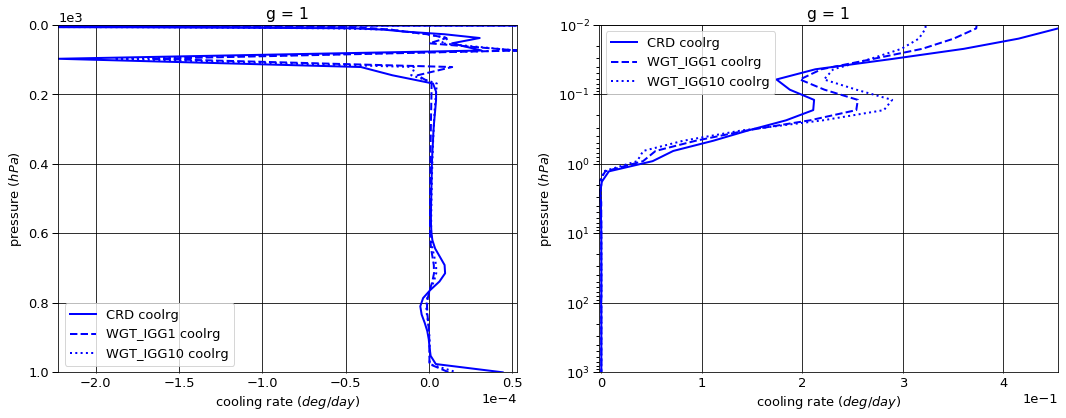

# Figure: cooling rate g-group 2

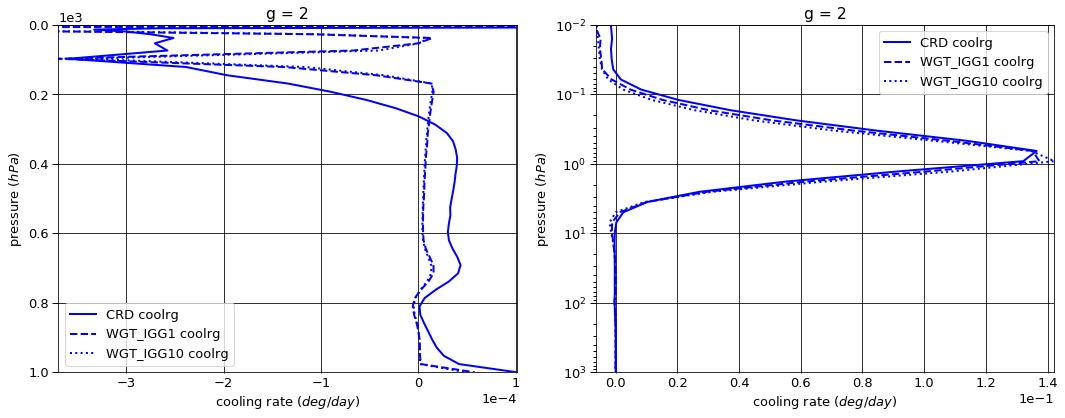

# Figure: cooling rate g-group 3

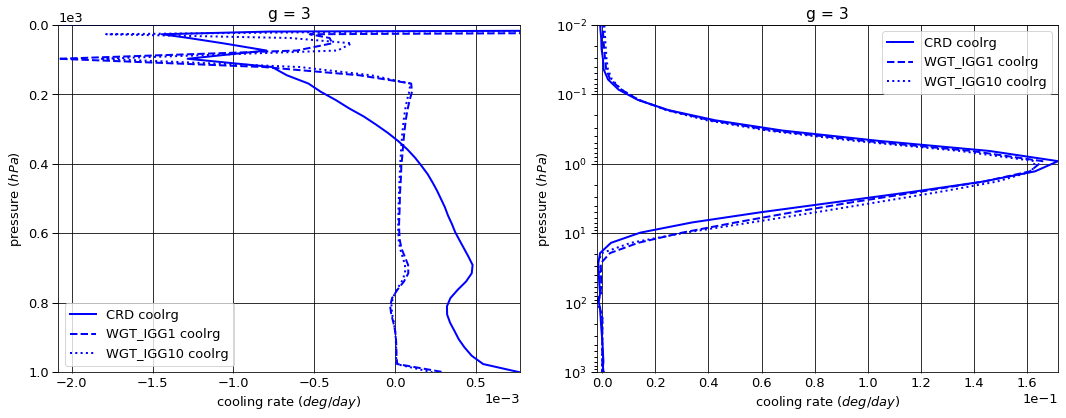

# Figure: cooling rate g-group 4

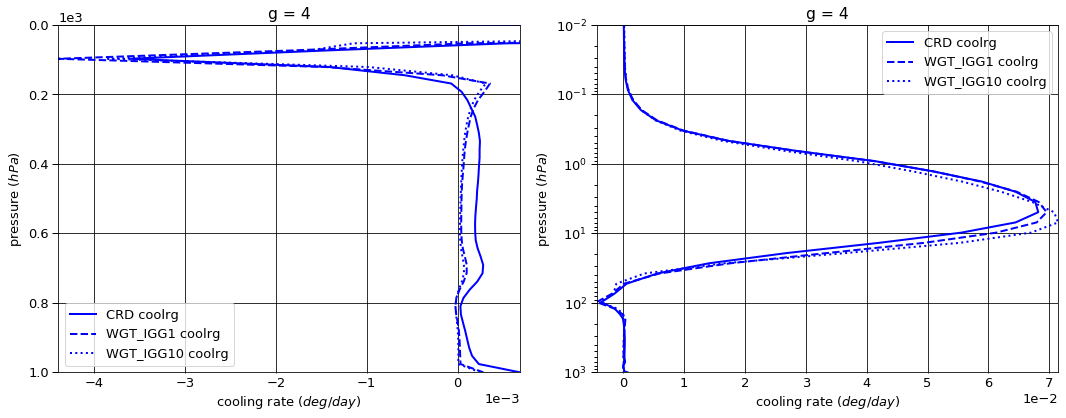

# Figure: cooling rate g-group 5

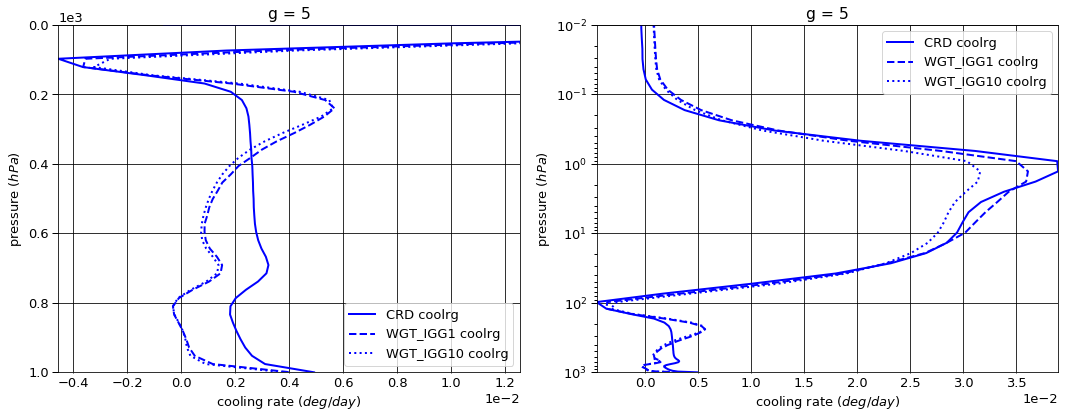

# Figure: cooling rate g-group 6

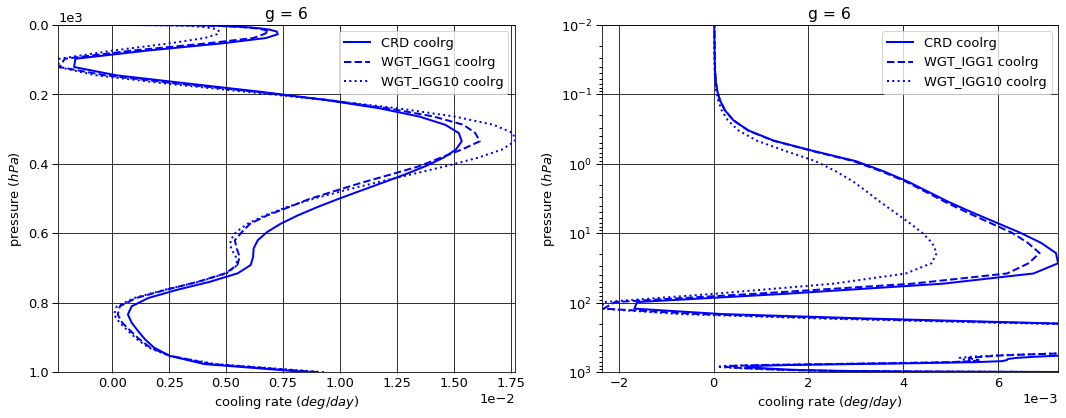

# Figure: cooling rate g-group 7

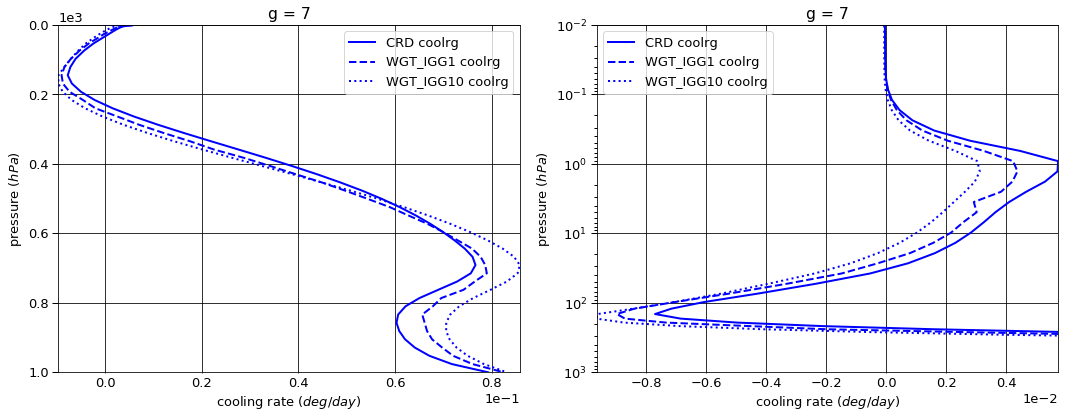

# Figure: cooling rate g-group 8

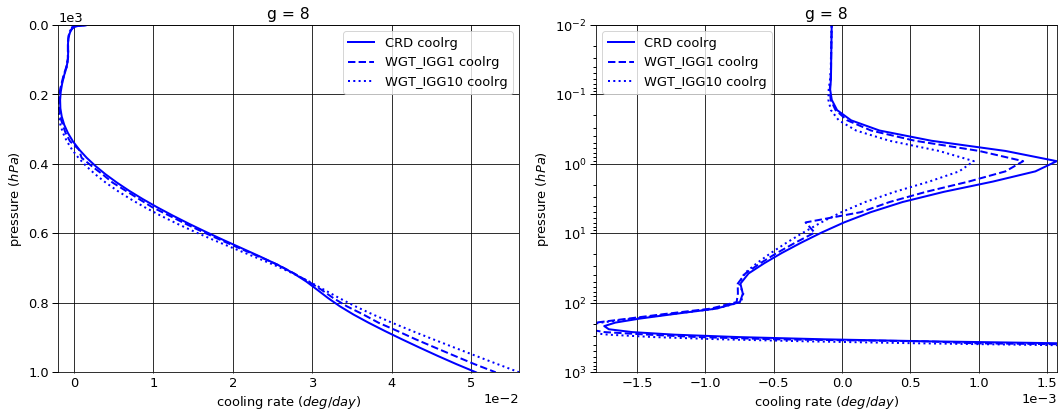

# Figure: cooling rate g-group 9

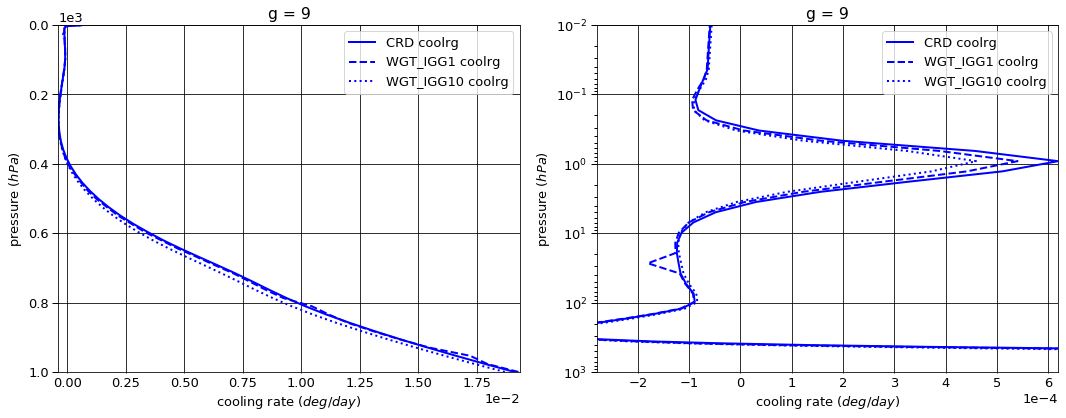

# Figure: cooling rate g-group total

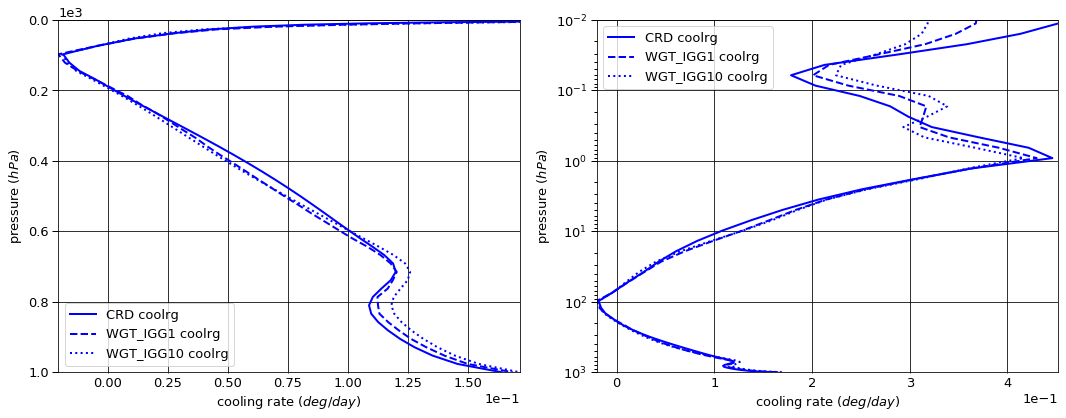

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014733  0.000000  -0.014733
  1013.0   76     -0.040829  0.040691  -0.000138
2 0.0      1      -0.023508  0.000000  -0.023508
  1013.0   76     -0.042695  0.042093  -0.000603
3 0.0      1      -0.108200  0.000000  -0.108200
  1013.0   76     -0.222130  0.205400  -0.016730
4 0.0      1      -0.149902  0.000000  -0.149902
  1013.0   76     -0.430133  0.425561  -0.004571
5 0.0      1      -0.494419  0.000000  -0.494419
  1013.0   76     -1.383392  1.276970  -0.106422
6 0.0      1      -0.848308  0.000000  -0.848308
  1013.0   76     -2.450671  2.406164  -0.044507
7 0.0      1      -6.588322  0.000000  -6.588322
  1013.0   76    -10.421166  8.773812  -1.647353
8 0.0      1      -6.735412  0.000000  -6.735412
  1013.0   76     -7.498147  2.600123  -4.898024
9 0.0      1     -12.566853  0.000000 -12.566853
  1013.0   76    -12.734346  0.713815 -12.020531


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014058  0.000000  -0.014058
  1013.0   76     -0.040829  0.040796  -0.000033
2 0.0      1      -0.024132  0.000000  -0.024132
  1013.0   76     -0.042695  0.042531  -0.000165
3 0.0      1      -0.099151  0.000000  -0.099151
  1013.0   76     -0.222130  0.221266  -0.000864
4 0.0      1      -0.149312  0.000000  -0.149312
  1013.0   76     -0.430133  0.429385  -0.000748
5 0.0      1      -0.339587  0.000000  -0.339587
  1013.0   76     -1.383392  1.368098  -0.015294
6 0.0      1      -0.803771  0.000000  -0.803771
  1013.0   76     -2.450671  2.405141  -0.045530
7 0.0      1      -6.624251  0.000000  -6.624251
  1013.0   76    -10.421166  8.745110  -1.676056
8 0.0      1      -6.734392  0.000000  -6.734392
  1013.0   76     -7.498147  2.627910  -4.870237
9 0.0      1     -12.567481  0.000000 -12.567481
  1013.0   76    -12.734346  0.711279 -12.023067


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.013776  0.000000  -0.013776
  1013.0   76     -0.040829  0.040783  -0.000046
2 0.0      1      -0.024494  0.000000  -0.024494
  1013.0   76     -0.042695  0.042557  -0.000138
3 0.0      1      -0.100965  0.000000  -0.100965
  1013.0   76     -0.222130  0.221482  -0.000648
4 0.0      1      -0.151559  0.000000  -0.151559
  1013.0   76     -0.430133  0.429445  -0.000688
5 0.0      1      -0.326443  0.000000  -0.326443
  1013.0   76     -1.383392  1.370208  -0.013183
6 0.0      1      -0.813118  0.000000  -0.813118
  1013.0   76     -2.450671  2.405536  -0.045135
7 0.0      1      -6.659596  0.000000  -6.659596
  1013.0   76    -10.421166  8.919582  -1.501583
8 0.0      1      -6.769544  0.000000  -6.769544
  1013.0   76     -7.498147  2.610192  -4.887955
9 0.0      1     -12.579576  0.000000 -12.579576
  1013.0   76    -12.734346  0.669340 -12.065006


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.742840e-04  0.000000  0.000674
  1013.0   76     6.938894e-18  0.000104  0.000104
2 0.0      1     -6.233460e-04  0.000000 -0.000623
  1013.0   76     0.000000e+00  0.000438  0.000438
3 0.0      1      9.048461e-03  0.000000  0.009048
  1013.0   76     0.000000e+00  0.015866  0.015866
4 0.0      1      5.895400e-04  0.000000  0.000590
  1013.0   76     0.000000e+00  0.003824  0.003824
5 0.0      1      1.548315e-01  0.000000  0.154831
  1013.0   76     0.000000e+00  0.091128  0.091128
6 0.0      1      4.453699e-02  0.000000  0.044537
  1013.0   76     0.000000e+00 -0.001023 -0.001023
7 0.0      1     -3.592880e-02  0.000000 -0.035929
  1013.0   76     0.000000e+00 -0.028702 -0.028702
8 0.0      1      1.019800e-03  0.000000  0.001020
  1013.0   76    -8.881784e-16  0.027786  0.027786
9 0.0      1     -6.280000e-04  0.000000 -0.000628
  1013.0   76     0.000000e+00 -0.002536 -0.002536


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      9.567860e-04  0.000000  0.000957
  1013.0   76     6.938894e-18  0.000091  0.000091
2 0.0      1     -9.858260e-04  0.000000 -0.000986
  1013.0   76     0.000000e+00  0.000464  0.000464
3 0.0      1      7.234900e-03  0.000000  0.007235
  1013.0   76     0.000000e+00  0.016082  0.016082
4 0.0      1     -1.657610e-03  0.000000 -0.001658
  1013.0   76     0.000000e+00  0.003883  0.003883
5 0.0      1      1.679761e-01  0.000000  0.167976
  1013.0   76     0.000000e+00  0.093239  0.093239
6 0.0      1      3.518972e-02  0.000000  0.035190
  1013.0   76     0.000000e+00 -0.000628 -0.000628
7 0.0      1     -7.127410e-02  0.000000 -0.071274
  1013.0   76     0.000000e+00  0.145770  0.145770
8 0.0      1     -3.413180e-02  0.000000 -0.034132
  1013.0   76    -8.881784e-16  0.010069  0.010069
9 0.0      1     -1.272300e-02  0.000000 -0.012723
  1013.0   76     0.000000e+00 -0.044475 -0.044475

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.453598
  1001.112500 75     0.000044
2 0.000312    1     -0.004900
  1001.112500 75     0.000102
3 0.000312    1     -0.002083
  1001.112500 75     0.000773
4 0.000312    1      0.000012
  1001.112500 75     0.000684
5 0.000312    1     -0.000644
  1001.112500 75     0.004925
6 0.000312    1      0.000006
  1001.112500 75     0.008666
7 0.000312    1     -0.000059
  1001.112500 75     0.079276
8 0.000312    1     -0.000066
  1001.112500 75     0.050638
9 0.000312    1     -0.000049
  1001.112500 75     0.019164


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.322390
  1001.112500 75     0.000012
2 0.000312    1     -0.008061
  1001.112500 75     0.000058
3 0.000312    1     -0.001296
  1001.112500 75     0.000305
4 0.000312    1      0.000042
  1001.112500 75     0.000282
5 0.000312    1      0.000549
  1001.112500 75     0.004056
6 0.000312    1      0.000008
  1001.112500 75     0.009147
7 0.000312    1     -0.000056
  1001.112500 75     0.082456
8 0.000312    1     -0.000066
  1001.112500 75     0.053122
9 0.000312    1     -0.000049
  1001.112500 75     0.019331


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.232706
  1001.112500 75     0.000017
2 0.000312    1     -0.008149
  1001.112500 75     0.000049
3 0.000312    1     -0.000616
  1001.112500 75     0.000232
4 0.000312    1      0.000057
  1001.112500 75     0.000248
5 0.000312    1      0.000533
  1001.112500 75     0.003806
6 0.000312    1      0.000005
  1001.112500 75     0.009374
7 0.000312    1     -0.000073
  1001.112500 75     0.083146
8 0.000312    1     -0.000066
  1001.112500 75     0.056075
9 0.000312    1     -0.000046
  1001.112500 75     0.018751


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.312076e-01
  1001.112500 75    -3.229755e-05
2 0.000312    1     -3.160522e-03
  1001.112500 75    -4.348181e-05
3 0.000312    1      7.867726e-04
  1001.112500 75    -4.675866e-04
4 0.000312    1      3.009125e-05
  1001.112500 75    -4.016833e-04
5 0.000312    1      1.192873e-03
  1001.112500 75    -8.681376e-04
6 0.000312    1      2.276936e-06
  1001.112500 75     4.818601e-04
7 0.000312    1      2.927815e-06
  1001.112500 75     3.180043e-03
8 0.000312    1      1.226000e-08
  1001.112500 75     2.484383e-03
9 0.000312    1     -6.071810e-07
  1001.112500 75     1.662180e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.208914e-01
  1001.112500 75    -2.759277e-05
2 0.000312    1     -3.248740e-03
  1001.112500 75    -5.221429e-05
3 0.000312    1      1.467151e-03
  1001.112500 75    -5.411840e-04
4 0.000312    1      4.478699e-05
  1001.112500 75    -4.362885e-04
5 0.000312    1      1.176874e-03
  1001.112500 75    -1.118686e-03
6 0.000312    1     -1.213262e-06
  1001.112500 75     7.086386e-04
7 0.000312    1     -1.472651e-05
  1001.112500 75     3.869792e-03
8 0.000312    1      6.278940e-07
  1001.112500 75     5.437897e-03
9 0.000312    1      2.640904e-06
  1001.112500 75    -4.136960e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.529657,0.00000,-27.529657
1013.0,76,-35.223509,16.48463,-18.738879



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.356137,0.000000,-27.356137
1013.0,76,-35.223509,16.591516,-18.631994



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.439072,0.000000,-27.439072
1013.0,76,-35.223509,16.709126,-18.514383



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.17352,0.000000,0.173520
1013.0,76,0.00000,0.106886,0.106885



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.090585,0.000000,0.090585
1013.0,76,0.000000,0.224496,0.224496


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.445815
1001.112500,75,0.164271



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.313461
1001.112500,75,0.168770



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.224351
1001.112500,75,0.171697



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.132354
1001.112500,75,0.004499



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.221464
1001.112500,75,0.007427


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001193
2,0.001187,0.001235
3,0.006188,0.006422
4,0.011875,0.012540
5,0.038500,0.040013
6,0.067937,0.071126
7,0.290187,0.301164
8,0.213688,0.211927
9,0.369312,0.354380


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.076063e-19
2,1.947095e-20
3,1.826139e-21
4,1.678020e-21
5,1.581825e-22
6,5.839038e-22
7,6.102842e-23
8,6.378566e-24
9,2.959058e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.076063e-19,NaN,0.001125,0.001193,0.001125,0.001193,1.0
2,1.947095e-20,0.093788,0.001187,0.001235,0.002312,0.002428,1.0
3,1.826139e-21,0.093788,0.006188,0.006422,0.008500,0.008850,1.0
4,1.678020e-21,0.918890,0.011875,0.012540,0.020375,0.021390,10.0
5,1.581825e-22,0.094267,0.038500,0.040013,0.058875,0.061403,10.0
6,5.839038e-22,3.691330,0.067937,0.071126,0.126812,0.132529,500.0
7,6.102842e-23,0.104518,0.290187,0.301164,0.417000,0.433693,500.0
8,6.378566e-24,0.104518,0.213688,0.211927,0.630687,0.645620,500.0
9,2.959058e-25,0.046391,0.369312,0.354380,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.563305e-19  3.118070e-19   1.784214  2.427171e-03
      2 0.000312     1.570789e-20  9.036739e-21   1.738225  6.196122e-05
      3 0.000312     1.000858e-21  6.673620e-22   1.499723  4.768415e-06
      4 0.000312     1.209647e-23  1.145605e-23   1.055903  6.301540e-08
      5 0.000312     2.091050e-23  1.155921e-23   1.808990  8.593886e-08
      6 0.000312     1.732535e-25  1.715849e-25   1.009725  9.109309e-10
      7 0.000312     3.328248e-25  2.692991e-25   1.235893  1.560038e-09
      8 0.000312     1.597599e-25  6.798737e-26   2.349847  7.728163e-10
      9 0.000312     4.948055e-26  6.394379e-27   7.738132  2.505204e-10
2     1 0.000750     5.591950e-19  3.131564e-19   1.785673  9.824477e-04
      2 0.000750     1.584616e-20  9.117209e-21   1.738050  2.517802e-05
      3 0.000750     1.011885e-21  6.731638e-22   1.503177  1.940822e-06
      4 0.000750     1.238616e-23  1.173188e-23   1.055769  2.599055e-08
      5 0.000750     2.117140e-23  1.166453e-23   1.815024  3.500544e-08
      6 0.000750     1.767997e-25  1.750891e-25   1.009769  3.744091e-10
      7 0.000750     3.374620e-25  2.725252e-25   1.238278  6.364445e-10
      8 0.000750     1.623672e-25  6.865430e-26   2.364997  3.162187e-10
      9 0.000750     5.033516e-26  6.445542e-27   7.809298  1.026428e-10
3     1 0.001052     5.650604e-19  3.158982e-19   1.788742  1.391573e-03
      2 0.001052     1.612640e-20  9.277609e-21   1.738206  3.593224e-05
      3 0.001052     1.033984e-21  6.841927e-22   1.511247  2.777930e-06
      4 0.001052     1.281268e-23  1.212908e-23   1.056361  3.769782e-08
      5 0.001052     2.169682e-23  1.186565e-23   1.828541  5.017735e-08
      6 0.001052     1.826520e-25  1.808532e-25   1.009947  5.423803e-10
      7 0.001052     3.468276e-25  2.789317e-25   1.243414  9.152358e-10
      8 0.001052     1.677403e-25  6.997888e-26   2.397013  4.577107e-10
      9 0.001052     5.210900e-26  6.548024e-27   7.957974  1.489988e-10
4     1 0.001476     5.710391e-19  3.187010e-19   1.791771  1.971977e-03
      2 0.001476     1.641591e-20  9.443454e-21   1.738338  5.131224e-05
      3 0.001476     1.056959e-21  6.956431e-22   1.519398  3.979006e-06
      4 0.001476     1.329096e-23  1.257628e-23   1.056828  5.485312e-08
      5 0.001476     2.224544e-23  1.207431e-23   1.842377  7.198171e-08
      6 0.001476     1.890496e-25  1.871567e-25   1.010114  7.874611e-10
      7 0.001476     3.566209e-25  2.855934e-25   1.248702  1.317176e-09
      8 0.001476     1.733695e-25  7.134254e-26   2.430100  6.630480e-10
      9 0.001476     5.396942e-26  6.653853e-27   8.111003  2.164653e-10
5     1 0.002070     5.770473e-19  3.215281e-19   1.794703  2.793732e-03
      2 0.002070     1.671128e-20  9.613007e-21   1.738403  7.326353e-05
      3 0.002070     1.080572e-21  7.074521e-22   1.527414  5.698997e-06
      4 0.002070     1.383249e-23  1.308535e-23   1.057097  8.006510e-08
      5 0.002070     2.281175e-23  1.228916e-23   1.856250  1.032586e-07
      6 0.002070     1.960657e-25  1.940740e-25   1.010263  1.145355e-09
      7 0.002070     3.667442e-25  2.924474e-25   1.254052  1.895473e-09
      8 0.002070     1.791916e-25  7.273138e-26   2.463746  9.603245e-10
      9 0.002070     5.589470e-26  6.761910e-27   8.266111  3.144043e-10
6     1 0.002904     5.830789e-19  3.243799e-19   1.797519  3.958155e-03
      2 0.002904     1.701291e-20  9.786814e-21   1.738351  1.046259e-04
      3 0.002904     1.104900e-21  7.197337e-22   1.535151  8.165150e-06
      4 0.002904     1.445986e-23  1.367885e-23   1.057096  1.174042e-07
      5 0.002904     2.339766e-23  1.251198e-23   1.870021  1.481819e-07
      6 0.002904     2.038986e-25  2.018032e-25   1.010383  1.670679e-09
      7 0.002904     3.772310e-25  2.995238e-25   1.259436  2.728512e-09
      8 0.002904     1.852157e-25  7.415065e-26   2.497830  1.391100e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
